<p>
    <font face="Microsoft YaHei" size=3>Prepared by "Big Data Analytics", Fall 2020 [Group 1]
        <font style="color:#a569bd">SWE1709044 Cai Zijian</font>,
        <font style="color:#3498db">SWE1709267 Liu Yanfeng</font>,<br>
        <font style="color:#52be80">SWE1709346 Sun Ruitao</font>,
        <font style="color:#ce5687">SWE1709425 Xu Jiayun</font>,
        <font style="color:#92a029">SWE1709509 Zhang Xinming</font>,
        <font style="color:#0927a2">SWE1709520 Zhang Zhichao</font>
    </font>
</p>
<HR style="border:1 dashed #987cb9" width="100%" color=#987cb9 SIZE=1></HR>

# **Question 3 - Spark.ml API**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.getOrCreate()

## **Step 1 - Generate Dataset**

In [2]:
# Function used to generate lawful datapoint
# Volume OA:OA:OC is around 1:6:3, we will assign datapoints based on volume ratio
def getDataPoint():
    label = np.random.random()
    while True:
        # OA
        if label <= 0.1:
            x = 2 * np.random.random() - 1
            y = 2 * np.random.random() - 1
            z = 2 * np.random.random() - 1
            if x * x + y * y + z * z <= 1:
                return np.array([x, y, z, 0])
        # OB
        elif label <= 0.7:
            x = 4 * np.random.random() - 2
            y = 4 * np.random.random() - 2
            z = 2 * np.random.random() + 2
            if x * x + y * y <= 4 and 2 <= z and z <= 4:
                return np.array([x, y, z, 1])
        # OC
        else:
            x = 2.2 * np.random.random() + 0.9
            y = 2 * np.random.random() - 1
            z = 4 * np.random.random() - 2
            if (x - 2) ** 2 / 1.2 + y ** 2 + z ** 2 / 4 <= 1:
                return np.array([x, y, z, 2])

In [3]:
# Number of datapoints
n = 500000
# Store in Pandas Dataframe
df = pd.DataFrame(index = np.arange(n), columns = ['X', 'Y', 'Z', 'label'])
for i in range(n):
    df.loc[i] = getDataPoint()
df

,X,Y,Z,label
0,1.619051,0.660228,2.984571,1.0
1,-0.213512,0.197948,0.616201,0.0
2,0.511451,0.910893,2.415066,1.0
3,0.262996,-1.063110,2.129761,1.0
4,-0.478666,-0.692863,3.266573,1.0
...,...,...,...,...
499995,0.422002,-0.325273,3.067985,1.0
499996,1.197566,0.134543,1.297640,2.0
499997,-0.794742,-0.636815,3.326895,1.0
499998,0.783298,-0.658603,2.415538,1.0


## **Step 2 - Preprocessing**

In [4]:
# Convert pandas dataframe to spark dataframe
data = spark.createDataFrame(df)

In [5]:
# Convert the (x, y, z) into a feature vector
data = VectorAssembler(inputCols=['X', 'Y', 'Z'], outputCol="features").transform(data)
data.show(10)

+--------------------+-------------------+-------------------+-----+--------------------+
|                   X|                  Y|                  Z|label|            features|
+--------------------+-------------------+-------------------+-----+--------------------+
|  1.6190514370952198| 0.6602281223487907|  2.984571042160712|  1.0|[1.61905143709521...|
|-0.21351170405270636|0.19794752483875744| 0.6162009393429833|  0.0|[-0.2135117040527...|
|  0.5114508100138386| 0.9108931479745266| 2.4150655402492327|  1.0|[0.51145081001383...|
|   0.262996209924264| -1.063110018308067| 2.1297611989254066|  1.0|[0.26299620992426...|
| -0.4786663756287042|-0.6928631846639446| 3.2665733633910707|  1.0|[-0.4786663756287...|
| -0.5044912115803821| 0.6000475945961892|-0.4370782309066483|  0.0|[-0.5044912115803...|
| 0.11512715518570849| 1.6289383578597127|  2.993557372725035|  1.0|[0.11512715518570...|
| -1.4574419819554052|0.17287207598071763|  2.525673257192816|  1.0|[-1.4574419819554...|
|  1.84779

## **Step 3 - Logistic Regression Models for Classification**

In [6]:
# Logistic Regression Model with 9:1 training testing data split ratio
(trainingData, testData) = data.randomSplit([0.9, 0.1])

lr = LogisticRegression(labelCol="label", featuresCol="features")
model = lr.fit(trainingData)

predictions = model.transform(testData)
predictions.select("prediction", "label", "features").show(10)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g " % (accuracy))
print(model)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  1.0|[-1.9936562959414...|
|       1.0|  1.0|[-1.9931559436748...|
|       1.0|  1.0|[-1.9920717484157...|
|       1.0|  1.0|[-1.9804513720321...|
|       1.0|  1.0|[-1.9779059587584...|
|       1.0|  1.0|[-1.9772141736368...|
|       1.0|  1.0|[-1.9738365663522...|
|       1.0|  1.0|[-1.9718453562597...|
|       1.0|  1.0|[-1.9695205078707...|
|       1.0|  1.0|[-1.9628581456639...|
+----------+-----+--------------------+
only showing top 10 rows

Test Accuracy = 0.999579 
LogisticRegressionModel: uid=LogisticRegression_7409285edd75, numClasses=3, numFeatures=3


In [7]:
# Logistic Regression Model with 8:2 training testing data split ratio
(trainingData, testData) = data.randomSplit([0.8, 0.2])

lr = LogisticRegression(labelCol="label", featuresCol="features")
model = lr.fit(trainingData)

predictions = model.transform(testData)
predictions.select("prediction", "label", "features").show(10)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g " % (accuracy))
print(model)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  1.0|[-1.9957951241616...|
|       1.0|  1.0|[-1.9921001077815...|
|       1.0|  1.0|[-1.9915892714455...|
|       1.0|  1.0|[-1.9875380941476...|
|       1.0|  1.0|[-1.9865978069790...|
|       1.0|  1.0|[-1.9855298121683...|
|       1.0|  1.0|[-1.9831286114584...|
|       1.0|  1.0|[-1.9827700508218...|
|       1.0|  1.0|[-1.9821363527206...|
|       1.0|  1.0|[-1.9814860186717...|
+----------+-----+--------------------+
only showing top 10 rows

Test Accuracy = 0.999489 
LogisticRegressionModel: uid=LogisticRegression_c33521771a8c, numClasses=3, numFeatures=3


In [8]:
# Logistic Regression Model with 7:3 training testing data split ratio
(trainingData, testData) = data.randomSplit([0.7, 0.3])

lr = LogisticRegression(labelCol="label", featuresCol="features")
model = lr.fit(trainingData)

predictions = model.transform(testData)
predictions.select("prediction", "label", "features").show(10)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g " % (accuracy))
print(model)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  1.0|[-1.9966958299523...|
|       1.0|  1.0|[-1.9957951241616...|
|       1.0|  1.0|[-1.9917927028942...|
|       1.0|  1.0|[-1.9915892714455...|
|       1.0|  1.0|[-1.9890845951103...|
|       1.0|  1.0|[-1.9859017062179...|
|       1.0|  1.0|[-1.9857521245296...|
|       1.0|  1.0|[-1.9837550374777...|
|       1.0|  1.0|[-1.9822517339191...|
|       1.0|  1.0|[-1.9814860186717...|
+----------+-----+--------------------+
only showing top 10 rows

Test Accuracy = 0.999539 
LogisticRegressionModel: uid=LogisticRegression_bdbb0d622584, numClasses=3, numFeatures=3


## **Step 4 - Decision Tree Models for Classification**

In [9]:
# Decision Tree Model with 9:1 training testing data split ratio
(trainingData, testData) = data.randomSplit([0.9, 0.1])

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(trainingData)

predictions = model.transform(testData)
predictions.select("prediction", "label", "features").show(10)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g " % (accuracy))
print(model)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  1.0|[-1.9917945596460...|
|       1.0|  1.0|[-1.9915892714455...|
|       1.0|  1.0|[-1.9805789191353...|
|       1.0|  1.0|[-1.9767462931460...|
|       1.0|  1.0|[-1.9607802034914...|
|       1.0|  1.0|[-1.9592816285593...|
|       1.0|  1.0|[-1.9589634895005...|
|       1.0|  1.0|[-1.9565065755717...|
|       1.0|  1.0|[-1.9479758645141...|
|       1.0|  1.0|[-1.9447663713092...|
+----------+-----+--------------------+
only showing top 10 rows

Test Accuracy = 0.997219 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2202f7345995, depth=5, numNodes=15, numClasses=3, numFeatures=3


In [10]:
# Decision Tree Model with 8:2 training testing data split ratio
(trainingData, testData) = data.randomSplit([0.8, 0.2])

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(trainingData)

predictions = model.transform(testData)
predictions.select("prediction", "label", "features").show(10)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g " % (accuracy))
print(model)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  1.0|[-1.9936562959414...|
|       1.0|  1.0|[-1.9931695883219...|
|       1.0|  1.0|[-1.9908031491942...|
|       1.0|  1.0|[-1.9892697520425...|
|       1.0|  1.0|[-1.9884481888444...|
|       1.0|  1.0|[-1.9859017062179...|
|       1.0|  1.0|[-1.9822507599286...|
|       1.0|  1.0|[-1.9822389607292...|
|       1.0|  1.0|[-1.9800498416012...|
|       1.0|  1.0|[-1.9762199380974...|
+----------+-----+--------------------+
only showing top 10 rows

Test Accuracy = 0.998243 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_6dc495ac861a, depth=5, numNodes=13, numClasses=3, numFeatures=3


In [11]:
# Decision Tree Model with 7:3 training testing data split ratio
(trainingData, testData) = data.randomSplit([0.7, 0.3])

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(trainingData)

predictions = model.transform(testData)
predictions.select("prediction", "label", "features").show(10)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = %g " % (accuracy))
print(model)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  1.0|[-1.9978414004338...|
|       1.0|  1.0|[-1.9938879300378...|
|       1.0|  1.0|[-1.9936562959414...|
|       1.0|  1.0|[-1.9921001077815...|
|       1.0|  1.0|[-1.9920717484157...|
|       1.0|  1.0|[-1.9915892714455...|
|       1.0|  1.0|[-1.9902702540027...|
|       1.0|  1.0|[-1.9859017062179...|
|       1.0|  1.0|[-1.9855298121683...|
|       1.0|  1.0|[-1.9837550374777...|
+----------+-----+--------------------+
only showing top 10 rows

Test Accuracy = 0.997891 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2a0edb4b3280, depth=5, numNodes=17, numClasses=3, numFeatures=3


## **Step 5 - K-means Models for Clustering**

In [12]:
# K-means Model with K = 2
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(data)

predictions = model.transform(data)
predictions.show(10)
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.clusterCenters()
print("\nCluster Centers: ")
for center in centers:
    print(center)

+--------------------+-------------------+-------------------+-----+--------------------+----------+
|                   X|                  Y|                  Z|label|            features|prediction|
+--------------------+-------------------+-------------------+-----+--------------------+----------+
|  1.6190514370952198| 0.6602281223487907|  2.984571042160712|  1.0|[1.61905143709521...|         1|
|-0.21351170405270636|0.19794752483875744| 0.6162009393429833|  0.0|[-0.2135117040527...|         0|
|  0.5114508100138386| 0.9108931479745266| 2.4150655402492327|  1.0|[0.51145081001383...|         1|
|   0.262996209924264| -1.063110018308067| 2.1297611989254066|  1.0|[0.26299620992426...|         1|
| -0.4786663756287042|-0.6928631846639446| 3.2665733633910707|  1.0|[-0.4786663756287...|         1|
| -0.5044912115803821| 0.6000475945961892|-0.4370782309066483|  0.0|[-0.5044912115803...|         0|
| 0.11512715518570849| 1.6289383578597127|  2.993557372725035|  1.0|[0.11512715518570...|  

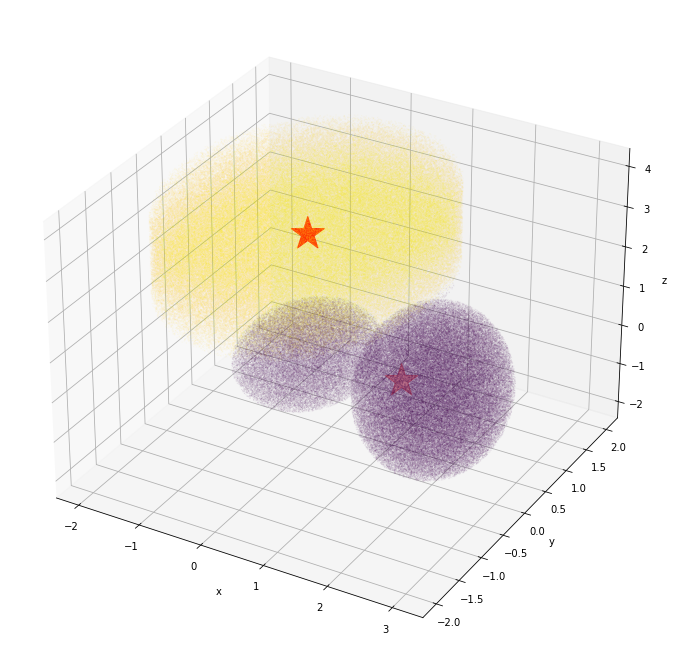

In [13]:
pic = plt.figure(figsize=(15,12)).gca(projection='3d')
centers = pd.DataFrame(centers)
pic.scatter(centers.iloc[:,0],centers.iloc[:,1],centers.iloc[:,2], c='r', marker='*', s=1200)
predi = predictions.select("*").toPandas()
pic.scatter(predi.iloc[:,0], predi.iloc[:,1], predi.iloc[:,2], c=predi.iloc[:,-1], marker='x', alpha=1/2, s=0.001)
pic.set_xlabel('x')
pic.set_ylabel('y')
pic.set_zlabel('z')
plt.show()

In [14]:
# K-means Model with K = 3
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(data)

predictions = model.transform(data)
predictions.show(10)
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.clusterCenters()
print("\nCluster Centers: ")
for center in centers:
    print(center)

+--------------------+-------------------+-------------------+-----+--------------------+----------+
|                   X|                  Y|                  Z|label|            features|prediction|
+--------------------+-------------------+-------------------+-----+--------------------+----------+
|  1.6190514370952198| 0.6602281223487907|  2.984571042160712|  1.0|[1.61905143709521...|         2|
|-0.21351170405270636|0.19794752483875744| 0.6162009393429833|  0.0|[-0.2135117040527...|         1|
|  0.5114508100138386| 0.9108931479745266| 2.4150655402492327|  1.0|[0.51145081001383...|         2|
|   0.262996209924264| -1.063110018308067| 2.1297611989254066|  1.0|[0.26299620992426...|         2|
| -0.4786663756287042|-0.6928631846639446| 3.2665733633910707|  1.0|[-0.4786663756287...|         0|
| -0.5044912115803821| 0.6000475945961892|-0.4370782309066483|  0.0|[-0.5044912115803...|         1|
| 0.11512715518570849| 1.6289383578597127|  2.993557372725035|  1.0|[0.11512715518570...|  

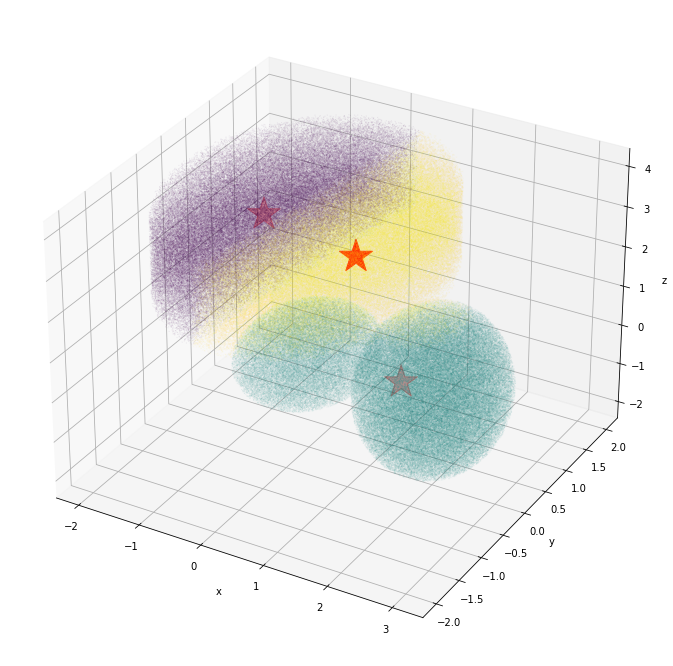

In [15]:
pic = plt.figure(figsize=(15,12)).gca(projection='3d')
centers = pd.DataFrame(centers)
pic.scatter(centers.iloc[:,0],centers.iloc[:,1],centers.iloc[:,2], c='r', marker='*', s=1200)
predi = predictions.select("*").toPandas()
pic.scatter(predi.iloc[:,0], predi.iloc[:,1], predi.iloc[:,2], c=predi.iloc[:,-1], marker='x', alpha=1/2, s=0.001)
pic.set_xlabel('x')
pic.set_ylabel('y')
pic.set_zlabel('z')
plt.show()

In [16]:
# K-means Model with K = 4
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(data)

predictions = model.transform(data)
predictions.show(10)
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.clusterCenters()
print("\nCluster Centers: ")
for center in centers:
    print(center)

+--------------------+-------------------+-------------------+-----+--------------------+----------+
|                   X|                  Y|                  Z|label|            features|prediction|
+--------------------+-------------------+-------------------+-----+--------------------+----------+
|  1.6190514370952198| 0.6602281223487907|  2.984571042160712|  1.0|[1.61905143709521...|         2|
|-0.21351170405270636|0.19794752483875744| 0.6162009393429833|  0.0|[-0.2135117040527...|         1|
|  0.5114508100138386| 0.9108931479745266| 2.4150655402492327|  1.0|[0.51145081001383...|         2|
|   0.262996209924264| -1.063110018308067| 2.1297611989254066|  1.0|[0.26299620992426...|         2|
| -0.4786663756287042|-0.6928631846639446| 3.2665733633910707|  1.0|[-0.4786663756287...|         0|
| -0.5044912115803821| 0.6000475945961892|-0.4370782309066483|  0.0|[-0.5044912115803...|         1|
| 0.11512715518570849| 1.6289383578597127|  2.993557372725035|  1.0|[0.11512715518570...|  

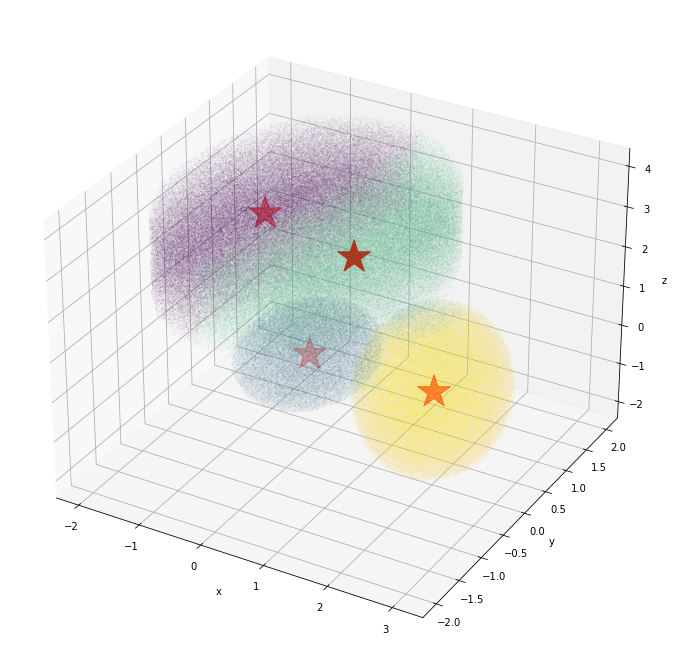

In [17]:
pic = plt.figure(figsize=(15,12)).gca(projection='3d')
centers = pd.DataFrame(centers)
pic.scatter(centers.iloc[:,0],centers.iloc[:,1],centers.iloc[:,2], c='r', marker='*', s=1200)
predi = predictions.select("*").toPandas()
pic.scatter(predi.iloc[:,0], predi.iloc[:,1], predi.iloc[:,2], c=predi.iloc[:,-1], marker='x', alpha=1/5, s=0.005)
pic.set_xlabel('x')
pic.set_ylabel('y')
pic.set_zlabel('z')
plt.show()